# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. The data collected from a Portuguese bank that used its own contact-center to do directed marketing campaigns. The telephone, with a human agent as the interlocutor, was the dominant marketing channel, although sometimes with an auxiliary use of the Internet online banking channel (e.g. by showing information to specific targeted client). Furthermore, each campaign was managed in an integrated fashion and the results for all channels were outputted together. The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts. During these phone campaigns, an attractive long-term deposit application, with good interest rates, was offered. For each contact, a large number of attributes was stored (e.g. see Table 2) and if there was a success (the target variable). For the whole database considered, there were 6499 successes (8% success rate).

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [314]:
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import time
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

In [244]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [245]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



#### Dropping for Any unknown values if present in the dataframe df

In [246]:
df = df.replace('unknown', np.nan)
df.dropna(inplace=True)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


#### Examining for datatypes for each columns

In [247]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30488 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30488 non-null  int64  
 1   job             30488 non-null  object 
 2   marital         30488 non-null  object 
 3   education       30488 non-null  object 
 4   default         30488 non-null  object 
 5   housing         30488 non-null  object 
 6   loan            30488 non-null  object 
 7   contact         30488 non-null  object 
 8   month           30488 non-null  object 
 9   day_of_week     30488 non-null  object 
 10  duration        30488 non-null  int64  
 11  campaign        30488 non-null  int64  
 12  pdays           30488 non-null  int64  
 13  previous        30488 non-null  int64  
 14  poutcome        30488 non-null  object 
 15  emp.var.rate    30488 non-null  float64
 16  cons.price.idx  30488 non-null  float64
 17  cons.conf.idx   30488 non-null 

Real-world data were collected from a Portuguese marketing campaign related with bank deposit subscription. The business goal is to find a model that can explain success of a contact, i.e. if the client subscribes the deposit. Such model can increase campaign efficiency by identifying the main characteristics that affect success, helping in a better management of the available resources (e.g. human effort, phone calls, time) and selection of a high quality and affordable set of potential buying customers.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

#### Extracting  the feature vectors 1-7 and encoding them into a meaningful one from the dataframe

In [249]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [250]:
X = df.iloc[:,1:8]

y = df['y']

In [251]:
X.head()

,job,marital,education,default,housing,loan,contact
0,housemaid,married,basic.4y,no,no,no,telephone
2,services,married,high.school,no,yes,no,telephone
3,admin.,married,basic.6y,no,no,no,telephone
4,services,married,high.school,no,no,yes,telephone
6,admin.,married,professional.course,no,no,no,telephone


#### Column transformation using one-hot encoding on features --- 'job', 'marital', 'education' and 'contact' and ordinal encoding on other features like --- "default", "housing" and "loan"

In [252]:
ohe = OneHotEncoder(drop='if_binary')

In [253]:
ode = OrdinalEncoder()

In [254]:
transform = make_column_transformer(
            (ohe, ['job', 'marital', 'education']),
            remainder = ode
)
transform

ColumnTransformer(remainder=OrdinalEncoder(),
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['job', 'marital', 'education'])])

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

The baseline model should try to maximize the area under ROC curve. As higher, the area under ROC plot, the plot would tend to stick towards upper left. This would allow the classifier to have higher True Positive Rate and lower True negative rate.

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [256]:
log_reg_pipe = Pipeline([
               ('col_transform', transform),
               ('logreg', LogisticRegression(max_iter=10000))
])
log_reg_start = time.time()
log_reg_pipe.fit(X_train, y_train)
log_reg_end = time.time()

### Problem 9: Score the Model

What is the accuracy of your model?

In [257]:
log_reg_train_time = log_reg_end - log_reg_start
log_reg_train_acc = accuracy_score(log_reg_pipe.predict(X_train), y_train)
log_reg_test_acc = accuracy_score(log_reg_pipe.predict(X_test), y_test)

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

#### Using KNN algorithm to build a model

In [258]:
knn_pipe = Pipeline([
               ('col_transform', transform),
               ('knn', KNeighborsClassifier())
])
knn_start = time.time()
knn_pipe.fit(X_train, y_train)
knn_end = time.time()

In [259]:
knn_train_time = knn_end - knn_start
knn_train_acc = accuracy_score(knn_pipe.predict(X_train), y_train)
knn_test_acc = accuracy_score(knn_pipe.predict(X_test), y_test)

#### Using Decision Tree algorithm to build a model

In [260]:
decision_tree_pipe = Pipeline([
               ('col_transform', transform),
               ('decision_tree', tree.DecisionTreeClassifier())
])
decision_tree_start = time.time()
decision_tree_pipe.fit(X_train, y_train)
decision_tree_end = time.time()

In [261]:
decision_tree_train_time = decision_tree_end - decision_tree_start
decision_tree_train_acc = accuracy_score(decision_tree_pipe.predict(X_train), y_train)
decision_tree_test_acc = accuracy_score(decision_tree_pipe.predict(X_test), y_test)

#### Using SVM algorithm to build a model

In [262]:
svm_pipe = Pipeline([
               ('col_transform', transform),
               ('svc', svm.SVC())
])
svm_start = time.time()
svm_pipe.fit(X_train, y_train)
svm_end = time.time()

In [263]:
svm_train_time = svm_end - svm_start
svm_train_acc = accuracy_score(svm_pipe.predict(X_train), y_train)
svm_test_acc = accuracy_score(svm_pipe.predict(X_test), y_test)

#### Creating a dataframe for different metrics of the models

In [264]:
df_accuracy = pd.DataFrame({'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'SVM'], 'Train Time': [log_reg_train_time, knn_train_time, decision_tree_train_time, svm_train_time], 'Train Accuracy': [log_reg_train_acc, knn_train_acc, decision_tree_train_acc, svm_train_acc], 'Test Accuracy': [log_reg_test_acc, knn_test_acc, decision_tree_test_acc, svm_test_acc]})

In [265]:
df_accuracy

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.118650,0.873984,0.872292
1,KNN,0.056960,0.873935,0.867720
2,Decision Tree,0.060480,0.877068,0.870205
3,SVM,3.001535,0.873984,0.872292


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

   #### Let's try to use all the features for the classification and observe the impact on accuracy

In [272]:
X = df.iloc[:,1:12]
X.drop(columns=['duration'], inplace=True)
y = df['y']

In [273]:
X

,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1
2,services,married,high.school,no,yes,no,telephone,may,mon,1
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,1
4,services,married,high.school,no,no,yes,telephone,may,mon,1
6,admin.,married,professional.course,no,no,no,telephone,may,mon,1
...,...,...,...,...,...,...,...,...,...,...
41183,retired,married,professional.course,no,yes,no,cellular,nov,fri,1
41184,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1
41185,retired,married,university.degree,no,yes,no,cellular,nov,fri,2
41186,technician,married,professional.course,no,no,no,cellular,nov,fri,1


In [274]:
X.dtypes

job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
campaign        int64
dtype: object

In [275]:
X['month'].value_counts()

may    9733
jul    5081
aug    4673
jun    3614
nov    3496
apr    2115
oct     642
sep     495
mar     482
dec     157
Name: month, dtype: int64

In [276]:
all_column_transform = make_column_transformer(
            (ohe, ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week']),
            remainder = StandardScaler()
)
all_column_transform

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'day_of_week'])])

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [283]:
log_reg_pipe = Pipeline([
               ('col_transform', all_column_transform),
               ('logreg', LogisticRegression(max_iter=10000))
])
log_reg_start = time.time()
log_reg_pipe.fit(X_train, y_train)
log_reg_end = time.time()

In [284]:
log_reg_train_time = log_reg_end - log_reg_start
log_reg_train_acc = accuracy_score(log_reg_pipe.predict(X_train), y_train)
log_reg_test_acc = accuracy_score(log_reg_pipe.predict(X_test), y_test)

In [285]:
knn_pipe = Pipeline([
               ('col_transform', all_column_transform),
               ('knn', KNeighborsClassifier())
])
knn_start = time.time()
knn_pipe.fit(X_train, y_train)
knn_end = time.time()

In [286]:
knn_train_time = knn_end - knn_start
knn_train_acc = accuracy_score(knn_pipe.predict(X_train), y_train)
knn_test_acc = accuracy_score(knn_pipe.predict(X_test), y_test)

In [287]:
decision_tree_pipe = Pipeline([
               ('col_transform', all_column_transform),
               ('decision_tree', tree.DecisionTreeClassifier())
])
decision_tree_start = time.time()
decision_tree_pipe.fit(X_train, y_train)
decision_tree_end = time.time()

In [288]:
decision_tree_train_time = decision_tree_end - decision_tree_start
decision_tree_train_acc = accuracy_score(decision_tree_pipe.predict(X_train), y_train)
decision_tree_test_acc = accuracy_score(decision_tree_pipe.predict(X_test), y_test)

In [289]:
svm_pipe = Pipeline([
               ('col_transform', all_column_transform),
               ('svc', svm.SVC())
])
svm_start = time.time()
svm_pipe.fit(X_train, y_train)
svm_end = time.time()

In [290]:
svm_train_time = svm_end - svm_start
svm_train_acc = accuracy_score(svm_pipe.predict(X_train), y_train)
svm_test_acc = accuracy_score(svm_pipe.predict(X_test), y_test)

In [291]:
df_accuracy_new = pd.DataFrame({'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'SVM'], 'Train Time': [log_reg_train_time, knn_train_time, decision_tree_train_time, svm_train_time], 'Train Accuracy': [log_reg_train_acc, knn_train_acc, decision_tree_train_acc, svm_train_acc], 'Test Accuracy': [log_reg_test_acc, knn_test_acc, decision_tree_test_acc, svm_test_acc]})

In [292]:
df_accuracy_new

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.123526,0.874865,0.871298
1,KNN,0.066821,0.890923,0.865037
2,Decision Tree,0.186064,0.952365,0.827370
3,SVM,10.728426,0.880300,0.873087


In [293]:
df_accuracy

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.118650,0.873984,0.872292
1,KNN,0.056960,0.873935,0.867720
2,Decision Tree,0.060480,0.877068,0.870205
3,SVM,3.001535,0.873984,0.872292


##### There is no considerable improvement in the accuracy of the model. So, it's not worth increasing the number of feture columns for the model selection

#### Let's try to apply GridSearchCV to optimize the hyper-parameters and maximize area under roc curve

##### Applying GridsearchCV on KNN model to optimize for the number of nearest neighbors

In [296]:

knn_pipe = Pipeline([
               ('col_transform', all_column_transform),
               ('knn', KNeighborsClassifier())
])
parameters_to_try = {'knn__n_neighbors': np.array(range(1,10))}
model_finder_knn = GridSearchCV(estimator = knn_pipe,
                                param_grid = parameters_to_try,
                                scoring = 'roc_auc',
                                cv=5)

In [297]:
model_finder_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_transform',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week'])])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='roc_auc')

In [299]:
best_knn_model = model_finder_knn.best_estimator_
best_knn_train_acc = accuracy_score(best_knn_model.predict(X_train), y_train)
best_knn_test_acc = accuracy_score(best_knn_model.predict(X_test), y_test)

0.8700059630292188

##### Applying GridsearchCV on Decision tree model to optimize for the max depth of tree

In [301]:
decision_tree_pipe = Pipeline([
               ('col_transform', all_column_transform),
               ('decision_tree', tree.DecisionTreeClassifier())
])
parameters_to_try = {'decision_tree__max_depth': np.array(range(1,100))}
model_finder_decision_tree = GridSearchCV(estimator = decision_tree_pipe,
                                param_grid = parameters_to_try,
                                scoring = 'roc_auc',
                                cv=5)

In [302]:
model_finder_decision_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_transform',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week'])])),
                                       ('decision_tree',
                                        DecisionTreeClassifier())]),
             param_grid={'decision_tree__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
             scoring='roc_auc')

In [303]:
best_decision_tree_model = model_finder_decision_tree.best_estimator_
best_decision_tree_train_acc = accuracy_score(best_decision_tree_model.predict(X_train), y_train)
best_decision_tree_test_acc = accuracy_score(best_decision_tree_model.predict(X_test), y_test)

In [304]:
best_decision_tree_test_acc

0.8713973365136156

##### Applying GridsearchCV on SVM model to optimize for the kernel functions

In [305]:
svc_pipe = Pipeline([
               ('col_transform', all_column_transform),
               ('svc', svm.SVC())
])
parameters_to_try = {'svc__kernel': np.array(['linear', 'quadratic', 'rbf'])}
model_finder_svm = GridSearchCV(estimator = svc_pipe,
                                param_grid = parameters_to_try,
                                scoring = 'roc_auc',
                                cv=5)

In [306]:
model_finder_svm.fit(X_train, y_train)

/Users/vivekkumarsharma/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/vivekkumarsharma/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vivekkumarsharma/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vivekkumarsharma/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py", line 18

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_transform',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week'])])),
                                       ('svc', SVC())]),
             param_grid={'svc__kernel': array(['linear', 'quadratic', 'rbf'], dtype='<U9')},
             scoring='roc_auc')

In [307]:
best_svm_model = model_finder_svm.best_estimator_
best_svm_train_acc = accuracy_score(best_svm_model.predict(X_train), y_train)
best_svm_test_acc = accuracy_score(best_svm_model.predict(X_test), y_test)

In [308]:
best_svm_test_acc

0.8730868614589545

##### Dataframe to capture accuracy for all different models after optimizing for hyper-parameters

In [309]:
pd.DataFrame({'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'SVM'], 'Train Accuracy': [log_reg_train_acc, best_knn_train_acc, best_decision_tree_train_acc, best_svm_train_acc], 'Test Accuracy': [log_reg_test_acc, best_knn_test_acc, best_decision_tree_test_acc, best_svm_test_acc]})

,Model,Train Accuracy,Test Accuracy
0,Logistic Regression,0.874865,0.871298
1,KNN,0.883041,0.870006
2,Decision Tree,0.888573,0.871397
3,SVM,0.880300,0.873087


#### The accuracy dataframe cleary shows that teh SVM model performs better than other models. Let's observe the RoC curve for all the models to decide on the best classifier

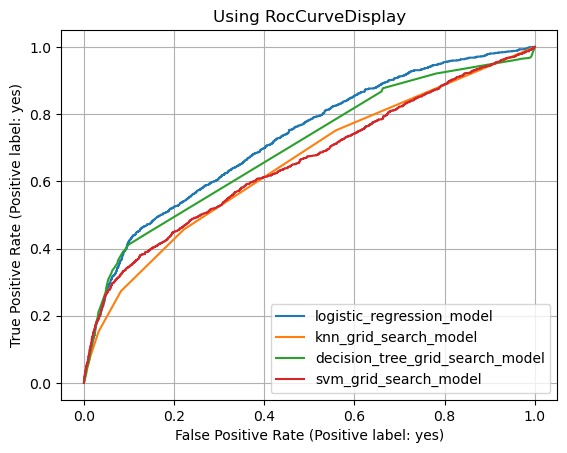

In [315]:
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(log_reg_pipe, X_test, y_test, pos_label = 'yes', ax = ax, label = 'logistic_regression_model')
RocCurveDisplay.from_estimator(model_finder_knn, X_test, y_test, pos_label = 'yes', ax = ax, label = 'knn_grid_search_model')
RocCurveDisplay.from_estimator(model_finder_decision_tree, X_test, y_test, pos_label = 'yes', ax = ax, label = 'decision_tree_grid_search_model')
RocCurveDisplay.from_estimator(model_finder_svm, X_test, y_test, pos_label = 'yes', ax = ax, label = 'svm_grid_search_model')
plt.grid()
plt.title('Using RocCurveDisplay')
plt.legend();

## CONCLUSION:

Inspite of the fact that,all the models have almost similar accuracy, logistic regression model performs much better in terms of roc curve. Logistic Regression model is the correct model for the dataset.
 